In [1]:
%matplotlib inline

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import seaborn as sns
import colorsys

from scripts import *
from sklearn.cluster import MiniBatchKMeans
from tqdm import tqdm

plt.rcParams['figure.figsize'] = 20, 5

In [3]:
def iterate_over_mask(img, mask):
    segments = np.unique(mask)
    
    for segment in segments:
        print(segment)
        yield segment, get_subimage(img, mask == segment)
        
def get_luminance_weighted_mask(img_hls, mask_function=get_rule_of_thirds_mask, mask_kwargs={}):
    mask = mask_function(img_hls, **mask_kwargs)

    replacements = {}
    for segment_idx, mask_subimg in iterate_over_mask(img_hls, mask):
        replacements[segment_idx] = np.median(mask_subimg[:,:,1])
        
    flat_mask = mask.flatten()
    return pd.Series(flat_mask).map(replacements).values.reshape(*mask.shape)

def get_subimage(img, mask):
    x = np.max(mask, 1).sum()
    y = np.max(mask, 0).sum()
    
    return np.moveaxis(np.stack(
        [np.extract(mask, img[:,:,0]).reshape(x, y)
        ,np.extract(mask, img[:,:,1]).reshape(x, y)
        ,np.extract(mask, img[:,:,2]).reshape(x, y)]
    ), 0, -1)

def get_palette(hls_palette):
    paleta = list(map(lambda cl: colorsys.hls_to_rgb(cl[0], cl[1], cl[2]), hls_palette))
    
    return paleta

def quantize_img(palette_index_matrix, palette=np_itten_color_wheel):
    shape = palette_index_matrix.shape
    
    return np.take(palette, palette_index_matrix.reshape(-1), axis=0).reshape(shape[0], shape[1], 3)

def quantize_img_color_wheel(img_hls, palette=np_itten_color_wheel):
    shape = img_hls.shape
    palette_index_matrix = get_color_wheel_quantized_img(img_hls, palette)
    
    return np.take(palette, palette_index_matrix.reshape(-1), axis=0).reshape(shape[0], shape[1], 3)

In [4]:
def get_img(img_path):
    img = cv2.imread(img_path)
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_hls = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HLS)
    
    return img_rgb, img_hls

# Paleta de Analisis

In [11]:
cam = glob.glob('../../Osintgram/output/*.jpg')

In [12]:
img = cam[0]
img_rgb, img_hls = get_img(img)

In [17]:
descr = pd.Series(img_hls[:,:, 2].flatten()).describe()

In [37]:
results = []
for img_path in tqdm(cam):
    img_rgb, img_hls = get_img(img_path)
    descr = pd.Series(img_hls[:,:,2].flatten()).describe()
    
    median = descr['50%']
    iqr = descr['75%'] - descr['25%']
    
    res = dict(zip(('median', 'iqr'), (median, iqr)))
    results.append(res)

100%|██████████| 1537/1537 [00:28<00:00, 53.61it/s]


In [38]:
pd_results = pd.DataFrame(results)

<AxesSubplot:xlabel='median', ylabel='iqr'>

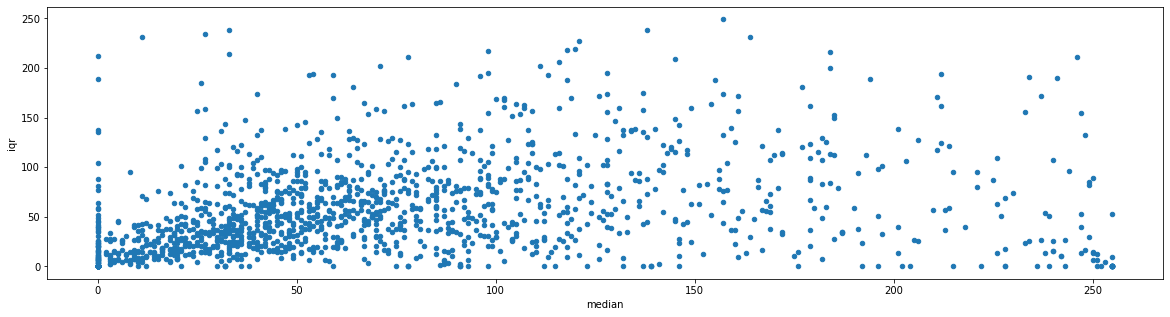

In [39]:
pd_results.plot.scatter(x='median', y='iqr')

In [83]:
pd_results[(pd_results['median'] == 0) & (pd_results['iqr'].between(1, 20))].sort_values(by='iqr')

,median,iqr
406,0.0,3.0
563,0.0,3.0
1034,0.0,3.0
572,0.0,4.0
1133,0.0,5.0
50,0.0,6.0
1214,0.0,6.0
1159,0.0,6.0
510,0.0,7.0
1399,0.0,7.0


In [86]:
img = cam[297]
img_rgb, img_hls = get_img(img)

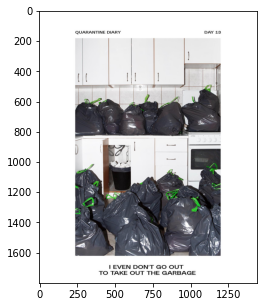

In [87]:
plt.imshow(img_rgb)